In [2]:
import os
import librosa   #thư viện xủ lý tín hiệu âm thanh
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #để đọc file wav 
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python 3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [7]:
train_audio_path = 'D:/DATA/voice/train/audio/'
labels=os.listdir(train_audio_path)
WORD = 8000
WORD_HALF = int(WORD/2)
CHUNK = 11000 
all_wave = []
all_label = []
all_feature = []
for label in labels:
    print("Label:",label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 16000)
        
        leng = len(samples)
        chunk_count = int(leng/CHUNK)
        word_count = 0
        for i in range(0,chunk_count):
            data = samples[i*CHUNK:(i+2)*CHUNK]
            mean = np.mean(data)
            energy = abs(data)
            value = 0
            max_val = 0
            max_idn = 0
            for idn in range(0,len(energy)):
                value += (energy[idn]-value)/1000
                if (idn>WORD_HALF) & (idn<(len(data)-WORD_HALF )):
                    if max_val<value:
                        max_val = value
                        max_idn = idn
            if max_val>(mean*3):
                word_count = word_count+1
                data = data[max_idn-WORD_HALF:max_idn+WORD_HALF]
                feature_vector = librosa.feature.melspectrogram(y=data, sr=16000)[:40]
                all_wave.append(data)
                all_feature.append(feature_vector)
                all_label.append(label)
        print(chunk_count," ",word_count)

Label: 0
68   68
1   1
1   1
1   1
1   1
1   1
Label: 1
66   66
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
Label: 2
66   66
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
Label: 3
68   68
1   1
1   0
1   0
1   1
1   0
1   1
1   0
1   1
1   0
1   1
1   0
1   0
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   0
1   0
1   1
1   0
1   1
1   1
Label: 4
67   67
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
Label: 5
68   68
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
Label: 6
67   67
Label: 7
67   67
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
1   1
Label: 8
67   67
1   1
1   1
1   1
1   1
1   1
1   1
1

4000
1.0662174888130362


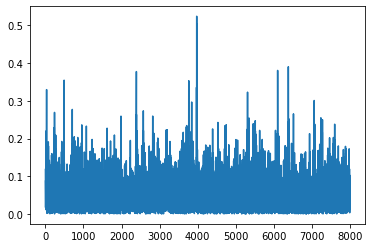

In [3]:
#test code
testId = 1000
energy = abs(all_wave[testId])
mean =np.mean(energy)
value = 0
max_val = 0
max_idn = 0
for idn in range(0,len(energy)):
    value += (energy[idn]-value)/1000
    if max_val<value:
        max_val = value
        max_idn = idn
plt.plot(energy)
print(max_idn)
print(max_val/mean)
# mean = np.mean(energy)*2
# cfar = [1 if e > mean else 0 for e in energy]
# plt.plot(cfar)

In [ ]:
#test code
len(all_wave[testId])

5


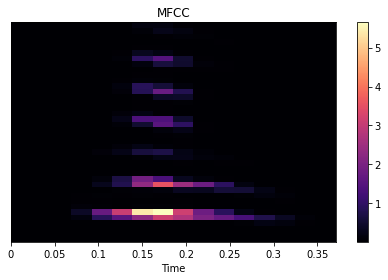

In [8]:
import matplotlib.pyplot as plt
import librosa.display

testId = 459
print(all_label[testId])
feature_vector = all_feature[testId]

# plt.figure(figsize=(20, 4))
# librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
# plt.colorbar()
# plt.title('melspectrogram')
# plt.tight_layout()
# plt.show()
librosa.display.specshow(feature_vector, x_axis='time') 
plt.colorbar() 
plt.title('MFCC') 
plt.tight_layout()
ipd.Audio(all_wave[testId], rate=16000)

In [9]:
#data preprocessing
from sklearn.preprocessing import LabelEncoder

all_feature = np.array(all_feature)
print(all_feature.shape)
feature_size = feature_vector.shape

le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
all_feature = np.array(all_feature).reshape(-1,feature_size[0],feature_size[1],1)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_feature),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

(1155, 40, 16)


Using TensorFlow backend.


In [ ]:
all_feature[1].shape

In [ ]:
print(tf.__version__)

In [10]:
x_tr.shape

(924, 40, 16, 1)

In [11]:
#thiết kế mô hình deep learning
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model1 = Sequential()

model1.add(Conv2D(16, kernel_size=(3, 3), strides= (2, 2), padding='same',data_format='channels_last',input_shape=(feature_size[0], feature_size[1],1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, kernel_size=(3, 3), strides= (1, 1), padding='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), strides= (1, 1), padding='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dropout(0.1))
model1.add(Dense(11))
model1.add(Activation('softmax'))
optimizer = Adam(lr=0.005)
opt = SGD(lr=0.005, momentum=0.9)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 8, 16)         160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 8, 16)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 4, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 4, 32)         4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10, 4, 32)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
________________________________________________

In [24]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,
                    epochs=10,
                    batch_size=200)

Epoch 1/10
924/924 [==============================] - 0s 49us/step - loss: 0.0629 - accuracy: 0.9848
Epoch 2/10
924/924 [==============================] - 0s 52us/step - loss: 0.0606 - accuracy: 0.9903
Epoch 3/10
924/924 [==============================] - 0s 49us/step - loss: 0.0629 - accuracy: 0.9892
Epoch 4/10
924/924 [==============================] - 0s 47us/step - loss: 0.0653 - accuracy: 0.9870
Epoch 5/10
924/924 [==============================] - 0s 51us/step - loss: 0.0545 - accuracy: 0.9903
Epoch 6/10
924/924 [==============================] - 0s 47us/step - loss: 0.0607 - accuracy: 0.9848
Epoch 7/10
924/924 [==============================] - 0s 47us/step - loss: 0.0591 - accuracy: 0.9881
Epoch 8/10
924/924 [==============================] - 0s 46us/step - loss: 0.0561 - accuracy: 0.9870
Epoch 9/10
924/924 [==============================] - 0s 47us/step - loss: 0.0657 - accuracy: 0.9848
Epoch 10/10
924/924 [==============================] - 0s 49us/step - loss: 0.0588 - accura

In [25]:
#kiểm tra mô hình sau khi luyện
for idn in range(0,800:

    output = model1.predict(all_feature)[idn]
    indexMax = np.argmax(output, axis=0) 
    if  int(all_label[idn]) != indexMax:
        print ( "id:",idn," prediction:",indexMax," value:", output[indexMax])
        print ("truth:",all_label[idn])
        
#     ipd.Audio(all_wave[testId], rate=16000)

id: 273  prediction: 2  value: 0.70060515
truth: 3
id: 274  prediction: 2  value: 0.70060515
truth: 3
id: 561  prediction: 2  value: 0.8440286
truth: 6
id: 563  prediction: 8  value: 0.6504694
truth: 6
id: 573  prediction: 8  value: 0.35523564
truth: 6
id: 574  prediction: 8  value: 0.35523564
truth: 6
id: 637  prediction: 8  value: 0.45381767
truth: 7
id: 639  prediction: 1  value: 0.7425833
truth: 7
id: 688  prediction: 5  value: 0.69790447
truth: 8
id: 785  prediction: 1  value: 0.96789247
truth: 9
id: 810  prediction: 2  value: 0.99576426
truth: 9


ValueError: invalid literal for int() with base 10: 'noise'

In [27]:
ipd.Audio(all_wave[785], rate=16000)

In [ ]:
all_label[idn]

In [ ]:
all_label[40]

In [28]:
# lưu kiến trúc của model đã luyện vào file json
model_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# lưu các trọng số của model
model1.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
